# PyCox
This notebook uses the surv_nn environment

Recreating this introduction to pycox
 - https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb


In [1]:
import torch
import numpy as np
import torchtuples as tt 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

In [5]:
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

In [6]:
for row, scaler in standardize:
    df_train[row] = scaler.fit_transform(df_train[row])
    df_test[row] = scaler.transform(df_test[row])
    df_val[row] = scaler.transform(df_val[row])


In [7]:
x_train = df_train[cols_standardize + cols_leave].astype('float32').to_numpy()
x_test = df_test[cols_standardize + cols_leave].astype('float32').to_numpy()
x_val = df_val[cols_standardize + cols_leave].astype('float32').to_numpy()

## Label Transforms

In [8]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

## Model

In [9]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.1),
    
     torch.nn.Linear(32, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.1),
   
     torch.nn.Linear(32, out_features)
)

In [10]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [11]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [12]:
batch_size = 256 #256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [13]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val) # , callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.0792,	val_loss: 2.9861
1:	[0s / 0s],		train_loss: 2.7489,	val_loss: 2.6268
2:	[0s / 0s],		train_loss: 2.4555,	val_loss: 2.2492
3:	[0s / 0s],		train_loss: 2.1038,	val_loss: 1.8631
4:	[0s / 0s],		train_loss: 1.7819,	val_loss: 1.5735
5:	[0s / 0s],		train_loss: 1.5585,	val_loss: 1.4190
6:	[0s / 0s],		train_loss: 1.4709,	val_loss: 1.3751
7:	[0s / 0s],		train_loss: 1.4167,	val_loss: 1.3655
8:	[0s / 0s],		train_loss: 1.4129,	val_loss: 1.3597
9:	[0s / 0s],		train_loss: 1.3746,	val_loss: 1.3548
10:	[0s / 0s],		train_loss: 1.3603,	val_loss: 1.3562
11:	[0s / 0s],		train_loss: 1.3416,	val_loss: 1.3552
12:	[0s / 0s],		train_loss: 1.3472,	val_loss: 1.3509
13:	[0s / 0s],		train_loss: 1.3369,	val_loss: 1.3479
14:	[0s / 0s],		train_loss: 1.3289,	val_loss: 1.3491
15:	[0s / 0s],		train_loss: 1.3208,	val_loss: 1.3516
16:	[0s / 0s],		train_loss: 1.3223,	val_loss: 1.3624
17:	[0s / 0s],		train_loss: 1.3227,	val_loss: 1.3621
18:	[0s / 0s],		train_loss: 1.2927,	val_loss: 1.3634
19:

<AxesSubplot:>

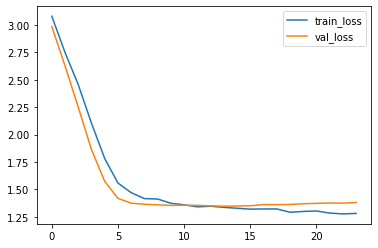

In [14]:
log.plot()

In [15]:
val

(array([[-0.38457575, -0.89326   , -0.74212027, ...,  0.        ,
          0.        ,  1.        ],
        [-0.3665086 , -0.3167301 ,  0.05380753, ...,  1.        ,
          0.        ,  1.        ],
        [-0.5659799 , -0.83177716, -0.9836813 , ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [-0.5302728 ,  0.5557188 ,  0.24615282, ...,  0.        ,
          0.        ,  1.        ],
        [-0.8310751 ,  0.80899894,  0.56936073, ...,  0.        ,
          0.        ,  1.        ],
        [-0.7328408 ,  0.42610374, -0.10061071, ...,  0.        ,
          0.        ,  1.        ]], dtype=float32),
 (array([3, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 1, 5, 3, 2, 1, 5, 3, 4, 0, 2, 5,
         7, 5, 4, 3, 2, 4, 5, 6, 1, 1, 3, 7, 1, 1, 4, 2, 4, 6, 6, 1, 3, 6,
         2, 2, 4, 1, 2, 3, 4, 2, 2, 5, 4, 1, 1, 3, 6, 1, 5, 2, 3, 6, 2, 5,
         3, 2, 5, 4, 4, 4, 2, 1, 3, 2, 5, 2, 8, 4, 1, 2, 2, 2, 3, 2, 4, 1,
         3, 3, 1, 2, 3, 1, 5, 2, 6, 2, 3, 3, 5, 2, 6, 2, 4

In [16]:
x_train.shape

(1218, 9)

# Prediction

In [17]:
surv = model.predict_surv_df(x_test)

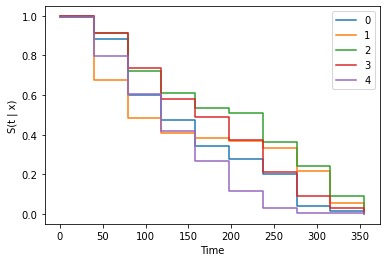

In [18]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [19]:
surv = model.interpolate(10).predict_surv_df(x_test)

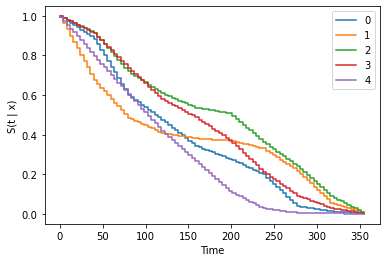

In [20]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [21]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [22]:
ev.concordance_td('antolini')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.660604519055492

# Comparison to CPH

In [23]:
cph = CoxPHFitter().fit(df_train, 'duration', 'event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1218 total observations, 482 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1218
number of events observed = 736
   partial log-likelihood = -4576.34
         time fit was run = 2022-10-17 02:17:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x0          0.04       1.04       0.04            -0.05             0.13                 0.96                 1.14
x1         -0.09       0.92       0.04            -0.17            -0.00                 0.84                 1.00
x2          0.10       1.11       0.04             0.03             0.18                 1.03                 1.20
x3          0.12       1.13       0.04             0.05             0.20                 1.05                 1.22
x4          0.10       1.10       0.08            -0.06             0.26                 0.94                 1.30
x5         -0.18       0.84       0.08            -0.33            -0.02                 0.72                 0.98
x6          0.93       2.54       0.12             0.69             1.17                 2.00                 3.23
x7          0.10       1.11       0.13            -0.14             0.35                 0.87                 1.42
x8          0.60       1.81       0.05             0.50             0.69                 1.65                 2.00

            cmp to     z      p   -log2(p)
covariate                                 
x0            0.00  0.93   0.35       1.50
x1            0.00 -1.99   0.05       4.43
x2            0.00  2.66   0.01       7.00
x3            0.00  3.17 <0.005       9.37
x4            0.00  1.19   0.23       2.09
x5            0.00 -2.26   0.02       5.40
x6            0.00  7.65 <0.005      45.50
x7            0.00  0.83   0.40       1.30
x8            0.00 12.15 <0.005     110.46
---
Concordance = 0.64
Partial AIC = 9170.69
log-likelihood ratio test = 212.43 on 9 df
-log2(p) of ll-ratio test = 133.17

In [24]:
cph.score(df_test, scoring_method = "concordance_index")

0.6503455000211963